In [ ]:
from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.vision.all import *

In [ ]:
from nbdev.showdoc import *

# Tutorial - Training a model on Imagenette

> A dive into the layered API of fastai in computer vision

The fastai library as a layered API as summarized by this graph:

![A layered API](images/layered.PNG)

If you are following this tutorial, you are probably already familiar with the applications, here we will see how they are powered by the high-level and mid-level API. 

[Imagenette](https://github.com/fastai/imagenette) is a subset of ImageNet with 10 very different classes. It's great to quickly experiment before trying a fleshed-out technique on the full ImageNet dataset. We will show in this tutorial how to train a model on it, using the usual high-level APIs, then delving inside the fastai library to show you how to use the mid-level APIs we designed. This way you'll be able to customize your own data collection or trainings as needed. 

## Assemble the data

We will look at several ways to get our data in `DataLoaders`: first we will use `ImageDataLoaders` factory methods (application layer), then the data block API (high level API) and lastly, how to do the same thing with the mid-level API.

### Loading the data with a factory method

This is the most basic way of assembling the data that we present in all the beginner tutorials, so hopefully it should be familiar to you now.

First, we import everything inside the vision application:

In [ ]:
from fastai2.vision.all import *

Then we download the dataset and decompress it (if needed) and get its location:

In [ ]:
path = untar_data(URLs.IMAGENETTE_160)

We use `ImageDataLoaders.from_folder` to get everything (since our data is organized in an imageNet-style format):

In [ ]:
dls = ImageDataLoaders.from_folder(path, valid='val', 
    item_tfms=RandomResizedCrop(128, min_scale=0.35), batch_tfms=Normalize.from_stats(*imagenet_stats))

And we can have a look at our data:

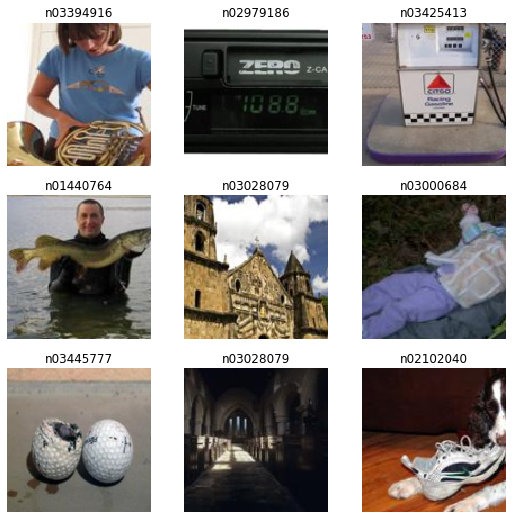

In [ ]:
dls.show_batch()

### Loading the data with the data block API

And as we saw, the `get_image_files` function helps get all the images in subfolders:

In [ ]:
fnames = get_image_files(path)

Let's begin with an empty `DataBlock`.

In [ ]:
dblock = DataBlock()

By itself, a `DataBlock` is just a blue print on how to assemble your data. It does not do anything until you pass it a source. You can choose to then convert that source into a `Datasets` or a `DataLoaders` by using the `DataBlock.datasets` or `DataBlock.dataloaders` method. Since we haven't done anything to get our data ready for batches, the `dataloaders` method will fail here, but we can have a look at how it gets converted in `Datasets`. This is where we pass the source of our data, here all our filenames:

In [ ]:
dsets = dblock.datasets(fnames)
dsets.train[0]

(Path('/home/sgugger/.fastai/data/imagenette2-160/train/n03000684/n03000684_14453.JPEG'),
 Path('/home/sgugger/.fastai/data/imagenette2-160/train/n03000684/n03000684_14453.JPEG'))

By default, the data block API assumes we have an input and a target, which is why we see our filename repeated twice. 

The first thing we can do is use a `get_items` function to actually assemble our items inside the data block:

In [ ]:
dblock = DataBlock(get_items = get_image_files)

The difference is that you then pass as a source the folder with the images and not all the filenames:

In [ ]:
dsets = dblock.datasets(path)
dsets.train[0]

(Path('/home/sgugger/.fastai/data/imagenette2-160/train/n03425413/n03425413_16978.JPEG'),
 Path('/home/sgugger/.fastai/data/imagenette2-160/train/n03425413/n03425413_16978.JPEG'))

Our inputs are ready to be processed as images (since images can be built from filenames), but our target is not. We need to convert that filename to a class name. For this, fastai provides `parent_label`:

In [ ]:
parent_label(fnames[0])

'n03425413'

This is not very readable, so since we can actually make the function we want, let's convert those obscure labels to something we can read:

In [ ]:
lbl_dict = dict(
    n01440764='tench',
    n02102040='English springer',
    n02979186='cassette player',
    n03000684='chain saw',
    n03028079='church',
    n03394916='French horn',
    n03417042='garbage truck',
    n03425413='gas pump',
    n03445777='golf ball',
    n03888257='parachute'
)

In [ ]:
def label_func(fname):
    return lbl_dict[parent_label(fname)]

We can then tell our data block to use it to label our target by passing it as `get_y`:

In [ ]:
dblock = DataBlock(get_items = get_image_files,
                   get_y     = label_func)

dsets = dblock.datasets(path)
dsets.train[0]

(Path('/home/sgugger/.fastai/data/imagenette2-160/val/n01440764/n01440764_9931.JPEG'),
 'tench')

Now that our inputs and targets are ready, we can specify types to tell the data block API that our inputs are images and our targets are categories. Types are represented by blocks in the data block API, here we use `ImageBlock` and `CategoryBlock`:

In [ ]:
dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                   get_items = get_image_files,
                   get_y     = label_func)

dsets = dblock.datasets(path)
dsets.train[0]

(PILImage mode=RGB size=240x160, TensorCategory(0))

We can see how the `DataBlock` automatically added the transforms necessary to open the image, or how it changed the name "cat" to an index (with a special tensor type). To do this, it created a mapping from categories to index called "vocab" that we can access this way:

In [ ]:
dsets.vocab

(#10) ['English springer','French horn','cassette player','chain saw','church','garbage truck','gas pump','golf ball','parachute','tench']

Note that you can mix an match any block for input and targets, which is why the API is named data block API. You can also have more than two blocks (if you have multiple inputs and/or targets), you would just need to pass `n_inp` to the `DataBlock` to tell the library how many inputs there are (the rest would be targets) and pass a list of functions to `get_x` and/or `get_y` (to explain how to process each item to be ready for his type). See the object detection below for such an example.

The next step is to control how our validation set is created. We do this by passing a `splitter` to `DataBlock`. For instance, here is how split by grandparent folder.

In [ ]:
dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                   get_items = get_image_files,
                   get_y     = label_func,
                   splitter  = GrandparentSplitter())

dsets = dblock.datasets(path)
dsets.train[0]

(PILImage mode=RGB size=160x357, TensorCategory(6))

The last step is to specify item transforms and batch transforms (the same way we do it in `ImageDataLoaders` factory methods):

In [ ]:
dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                   get_items = get_image_files,
                   get_y     = label_func,
                   splitter  = GrandparentSplitter(),
                   item_tfms = RandomResizedCrop(128, min_scale=0.35), 
                   batch_tfms=Normalize.from_stats(*imagenet_stats))

We that resize, we are now able to batch items together and can finally call `dataloaders` to convert our `DataBlock` to a `DataLoaders` object:

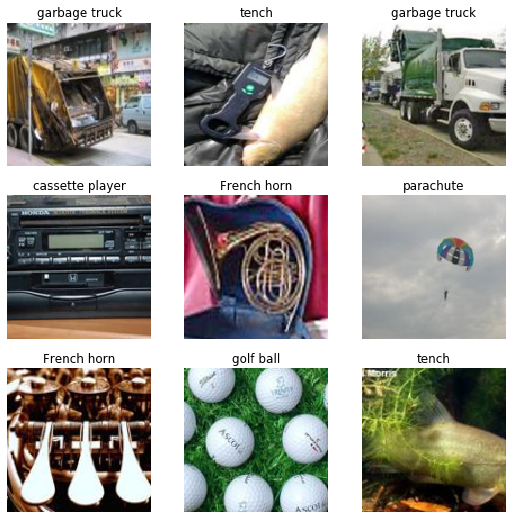

In [ ]:
dls = dblock.dataloaders(path)
dls.show_batch()

Another way to compose several functions for `get_y` is to put them in a `Pipeline`:

In [ ]:
imagenette = DataBlock(blocks = (ImageBlock, CategoryBlock),
                       get_items = get_image_files,
                       get_y = Pipeline([parent_label, lbl_dict.__getitem__]),
                       splitter = GrandparentSplitter(valid_name='val'),
                       item_tfms = RandomResizedCrop(128, min_scale=0.35),
                       batch_tfms = Normalize.from_stats(*imagenet_stats))

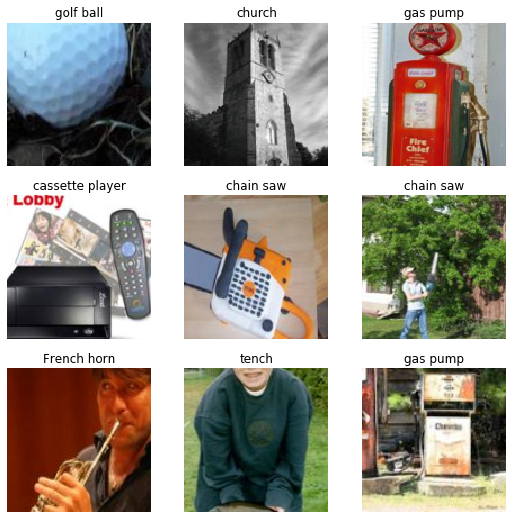

In [ ]:
dls = imagenette.dataloaders(path)
dls.show_batch()

To learn more about the data block API, checkout the [data block tutorial](http://dev.fast.ai/tutorial.datablock)!

### Loading the data with the mid-level API

To load the data with the medium-level API `Datasets`, we need to gather all the images and define some way to split them between training and validation sets.

In [ ]:
source = untar_data(URLs.IMAGENETTE_160)
items = get_image_files(source)
split_idx = GrandparentSplitter(valid_name='val')(items)

Then we detail the type transforms (applied to the items to form a tuple) and the dataset transforms. For our inputs we use `PILImage.create` and for our targets, the `parent_label` function to convert a filename to its class, followed by `Categorize`. We'll also map the wordnet category ids used in Imagenette to words.

The dataset transforms contain data augmentation using PIL and a resize to 128.

In [ ]:
lbl_dict = dict(
    n01440764='tench',
    n02102040='English springer',
    n02979186='cassette player',
    n03000684='chain saw',
    n03028079='church',
    n03394916='French horn',
    n03417042='garbage truck',
    n03425413='gas pump',
    n03445777='golf ball',
    n03888257='parachute'
)

In [ ]:
tfms = [[PILImage.create], [parent_label, lbl_dict.__getitem__, Categorize]]
item_img_tfms = [ToTensor, FlipItem(0.5), RandomResizedCrop(128, min_scale=0.35)]

We can then pass all of this information to `Datasets`.

In [ ]:
dsets = Datasets(items, tfms, splits=split_idx)

To convert our `Datasets` to a `DataLoaders`, we need to indicate the transforms we want to use at the batch level, here putting on the GPU with `Cuda`, converting the tensors of bytes to float then normalizing using the traditional imagenet statistics.

In [ ]:
batch_tfms = [IntToFloatTensor, Normalize.from_stats(*imagenet_stats)]
dls = dsets.dataloaders(after_item=item_img_tfms, after_batch=batch_tfms, bs=64, num_workers=0)

In [ ]:
items

(#13394) [Path('/home/sgugger/.fastai/data/imagenette2-160/val/n03425413/n03425413_12962.JPEG'),Path('/home/sgugger/.fastai/data/imagenette2-160/val/n03425413/ILSVRC2012_val_00035211.JPEG'),Path('/home/sgugger/.fastai/data/imagenette2-160/val/n03425413/n03425413_1381.JPEG'),Path('/home/sgugger/.fastai/data/imagenette2-160/val/n03425413/n03425413_13752.JPEG'),Path('/home/sgugger/.fastai/data/imagenette2-160/val/n03425413/n03425413_12701.JPEG'),Path('/home/sgugger/.fastai/data/imagenette2-160/val/n03425413/n03425413_10450.JPEG'),Path('/home/sgugger/.fastai/data/imagenette2-160/val/n03425413/n03425413_7022.JPEG'),Path('/home/sgugger/.fastai/data/imagenette2-160/val/n03425413/n03425413_8661.JPEG'),Path('/home/sgugger/.fastai/data/imagenette2-160/val/n03425413/n03425413_14891.JPEG'),Path('/home/sgugger/.fastai/data/imagenette2-160/val/n03425413/n03425413_21202.JPEG')...]

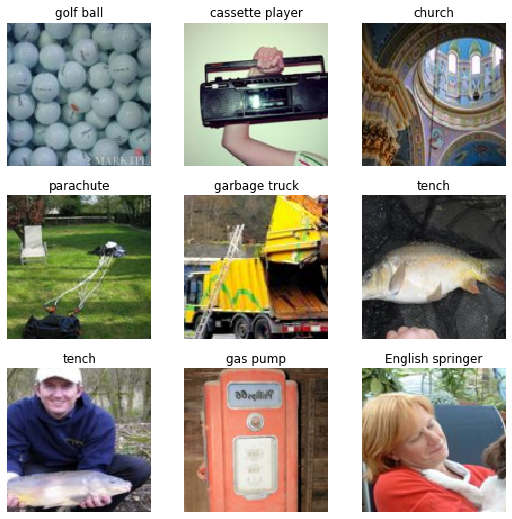

In [ ]:
dls.show_batch(max_n=9)

### Training

The following function will give us a `Learner` to train a model on imagenette.

In [ ]:
learn = Learner(dls, xresnet18(), lr=1e-2, metrics=accuracy,
                loss_func=LabelSmoothingCrossEntropy(),
                opt_func=partial(Adam, wd=0.01, eps=1e-3)
               ).to_fp16()

Then we can train our model.

In [ ]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,2.332943,2.108922,0.624459,00:31


## Showing results

To get predictions on one item, we use `Learner.predict`

In [ ]:
tst_item = items[0]
t = learn.predict(tst_item)

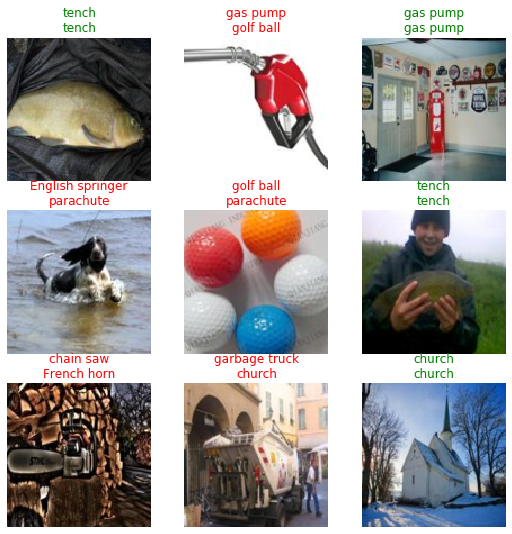

In [ ]:
learn.show_results()

### Side note: using a PyTorch optimizer

In [ ]:
@delegates(torch.optim.AdamW.__init__)
def pytorch_adamw(params, **kwargs):
    return OptimWrapper(torch.optim.AdamW(params, **kwargs))

In [ ]:
learn = Learner(dls, xresnet18(), lr=1e-2, metrics=accuracy,
                loss_func=LabelSmoothingCrossEntropy(),
                opt_func=partial(pytorch_adamw, wd=0.01, eps=1e-3)
               ).to_fp16()